# Doodle Classifier
This is a single layer Neural Network made with [TensorFlow](https://github.com/tensorflow/tensorflow) that classifies doodles into either pens or pineapples.

In [22]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import random
from IPython.display import clear_output
import matplotlib.pyplot as pl
%matplotlib inline

## Getting our data
Along with this repository are two files that contains all the doodles that we are going to use. However, we also must create the labels that our Neural Network should correctly guess. Those labels are going to be an array with two elements. If the first element is 1, then we say it's a pineapple, otherwise, if the second element is 1, it would be a pen.

In [23]:
#Load the images
pineapples_images = np.load('pineapple.npy')
pens_images = np.load('pen.npy')

#Create our pineapple and pen labels
pineapples_labels = np.zeros((pineapples_images.shape[0], 2))
pineapples_labels[:, 0] = 1;
pens_labels = np.zeros((pens_images.shape[0], 2))
pens_labels[:, 1] = 1

It's a good practise to take a look to our data. In this case, we can see that our images are indeed a 728 array. Each value represents a pixel of the doodle image.

In [24]:
print('Pineapples', pineapples_images.shape, pineapples_labels.shape)
print('Pens', pens_images.shape, pens_labels.shape)

('Pineapples', (125071, 784), (125071, 2))
('Pens', (122001, 784), (122001, 2))


## Creating our datasets
What we are going to do now is to create three datasets each one with one purpose: **training**, **testing** and **validation**. These datasets contains both the pens and pineapples doodles, that's why we concatenate them.

In [25]:
TRAIN_SIZE = 80000
train_dataset = np.concatenate((pineapples_images[0:TRAIN_SIZE], pens_images[0:TRAIN_SIZE]))
train_labels = np.concatenate((pineapples_labels[0:TRAIN_SIZE], pens_labels[0:TRAIN_SIZE]))

TEST_SIZE = 20000
offset = TRAIN_SIZE
test_dataset = np.concatenate((pineapples_images[offset:offset + TEST_SIZE], pens_images[offset:offset + TEST_SIZE]))
test_labels = np.concatenate((pineapples_labels[offset:offset + TEST_SIZE], pens_labels[offset:offset + TEST_SIZE]))

VALIDATION_SIZE = 10000
offset = offset + TEST_SIZE
validation_dataset = np.concatenate((pineapples_images[offset:offset + VALIDATION_SIZE], pens_images[offset:offset + VALIDATION_SIZE]))
validation_labels = np.concatenate((pineapples_labels[offset:offset + VALIDATION_SIZE], pens_labels[offset:offset + VALIDATION_SIZE]))

Again, let's see how our datasets look like:

In [26]:
print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)
print('Validation set', validation_dataset.shape, validation_labels.shape)

('Training set', (160000, 784), (160000, 2))
('Test set', (40000, 784), (40000, 2))
('Validation set', (20000, 784), (20000, 2))


So far so good, but now we have to face a little problem. As our datasets were concatenated, now all pineapples appears first, and that's no good as we want to get batches of both types of doodles at the same! But worry not, we can easily shuffle both arrays with this simple function:

In [27]:
def shuffle_images_and_labels(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

Great! Now you can shuffle our datasets, you can run this function as many times as you want and see how it's working.

pineapple


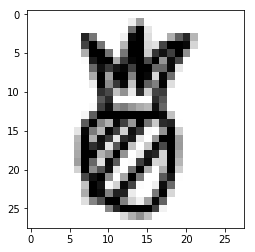

In [202]:
train_dataset, train_labels = shuffle_images_and_labels(train_dataset, train_labels)
test_dataset, test_labels = shuffle_images_and_labels(test_dataset, test_labels)
validation_dataset, validation_labels = shuffle_images_and_labels(validation_dataset, validation_labels)

sample = test_dataset[1]
sample = sample.reshape(28,28)
pl.imshow(sample, cmap="gray_r")
print("Pen" if (test_labels[1, 0] == 0) else "Pineapple")

## Our Neural Network!
Okey, let's do it. So we have a 784 pixels doodle. And also we have 160000 doodles to train our network. So... we could feed one by one to our NN. But that would be too slow. Feeding all of them at the same time would be quite overwhelming and would not let room for optimization, so the best approach is to define a batch size that will be the number of doodles that we are going to feed our Neural Network

In [210]:
BATCH_SIZE = 128

Great, now we know how to give all our data to our network, but we must create it first! To do this, we are going to define several things: how many **inputs** are we going to get each iteration, how many **outputs** will be predicted, the number of **weights and biases** that will change during the training fase, the **loss and optimizer** functions, how our NN will predict its output... This block of code does all of those things in our TensorFlow object graph, that would be our Neural Network. 

In [213]:
graph = tf.Graph()

with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape=[BATCH_SIZE, 28*28])
    tf_train_labels = tf.placeholder(tf.int64, shape=[BATCH_SIZE, 2])
    
    weights = tf.Variable(tf.random_uniform([784, 2]))
    biases = tf.Variable(tf.random_uniform([2]))
    
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=tf_train_labels))
    
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    tf_test_dataset = tf.cast(tf.constant(test_dataset), tf.float32)
    tf_validation_dataset = tf.cast(tf.constant(validation_dataset), tf.float32)
    
    train_prediction = tf.nn.softmax((tf.matmul(tf_train_dataset, weights) + biases))
    test_prediction = tf.nn.softmax((tf.matmul(tf_test_dataset, weights) + biases))
    validation_prediction = tf.nn.softmax((tf.matmul(tf_validation_dataset, weights) + biases))

## Place your bets
Now let's train our Neural Network. It knows what to do as we already defined its optimization and loss function, but in order to see if it is performing correctly, we are going to create an accuracy function that tells us how many correct predictions our NN does.

In [1]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.equal(np.argmax(predictions, 1), np.argmax(labels, 1))) / predictions.shape[0])

Okey, now everything it's ready. We are going to train our NN. To do this, we are going to do 10001 iterations, each one will take a batch of 128 doodles and our NN will try to approach a function that correctly predicts the doodle category. In order to visualize its progress, we'll print it's accuracy every 500 steps.

In [440]:
NUM_STEPS = 10001
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for step in range(NUM_STEPS):
        offset = (step * 128) % (train_labels.shape[0] - BATCH_SIZE)
        batch_data = train_dataset[offset:(offset + BATCH_SIZE), :]
        batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
        feed_dict = { tf_train_dataset: batch_data, tf_train_labels: batch_labels }
       
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if(step % 500 == 0):
            clear_output(wait=True)
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation error %.1f%%" % accuracy(validation_prediction.eval(), validation_labels))
    print("Successfully ended iteration %d" % step)
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Minibatch loss at step 10000: 20669.662109
Minibatch accuracy: 89.8%
Validation error 92.8%
Successfully ended iteration 10000
Test accuracy: 93.5%
